Enter the path of your dataset (CSV format):  /Users/kartikeysharma/Desktop/Hanuman/Projects/Prodigal Stock Data/Nifty50_data.csv
Enter start date (YYYY-MM-DD):  2015-03-03
Enter end date (YYYY-MM-DD):  2021-03-03
Enter your initial capital (in INR):  10000
Select a country (1: India, 2: USA, 3: Japan):  1
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  1


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/2726694808.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Adj Close'] < data['Lower Band']] = 1  # Buy signal
/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/2726694808.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Adj Close'] > data['Upper Band']] = -1 # Sell signal


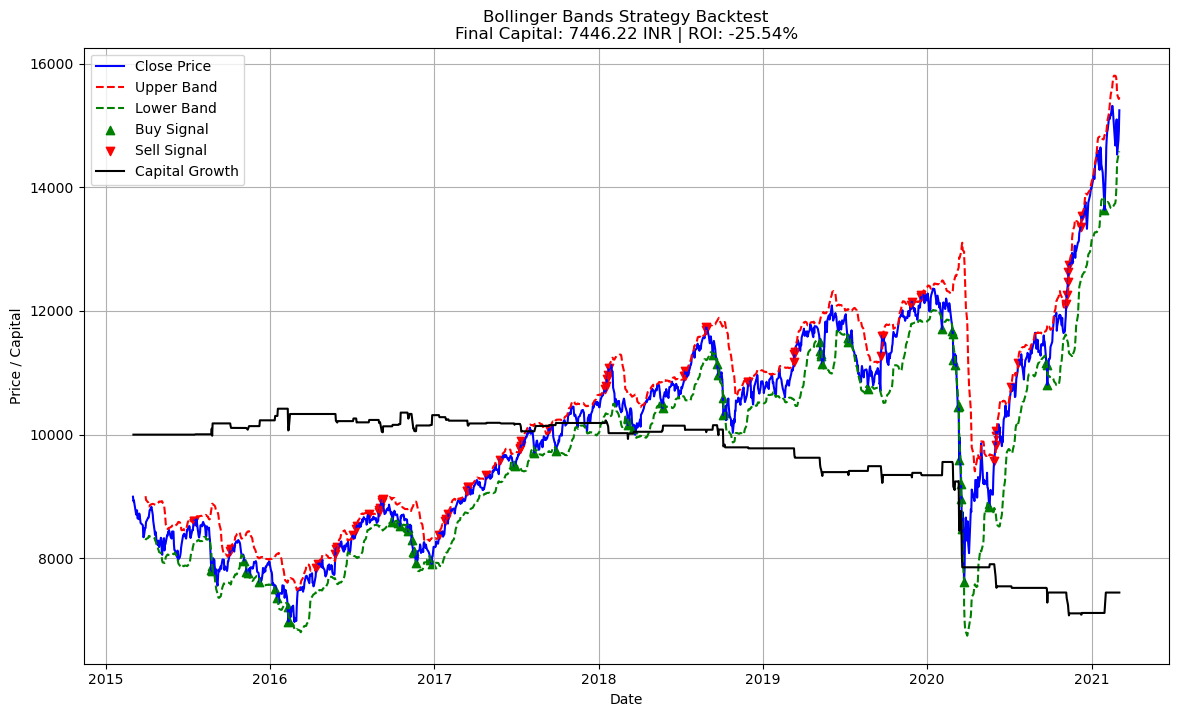


Final Capital: 7446.22 INR
ROI: -25.54%


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from forex_python.converter import CurrencyRates

# Currency converter instance
currency_converter = CurrencyRates()

# Function to convert currency
def convert_currency(amount, from_currency, to_currency):
    conversion_rate = currency_converter.get_rate(from_currency, to_currency)
    return amount * conversion_rate

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Adj Close'].rolling(window=window).mean()
    data['STD'] = data['Adj Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Adj Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Adj Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Adj Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to visualize the strategy along with capital and ROI
def visualize_strategy(data, strategy_name, initial_capital, target_currency):
    # Calculate returns and cumulative returns
    data['Position'] = data['Signal'].shift(1).fillna(0)
    data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Visualization
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    
    if strategy_name == 'Bollinger Bands':
        plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
        plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    
    elif strategy_name == 'SMA Crossover':
        plt.plot(data.index, data['SMA_Short'], label='Short-term SMA', color='orange')
        plt.plot(data.index, data['SMA_Long'], label='Long-term SMA', color='purple')

    plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Adj Close'], 
                label='Buy Signal', marker='^', color='green')
    plt.scatter(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['Adj Close'], 
                label='Sell Signal', marker='v', color='red')

    plt.plot(data.index, data['Capital'], label='Capital Growth', color='black')
    plt.title(f'{strategy_name} Strategy Backtest\nFinal Capital: {final_capital:.2f} {target_currency} | ROI: {roi:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Price / Capital')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"ROI: {roi:.2f}%")

# Main function to load data, apply strategies, and calculate ROI
def main():
    # Load dataset
    file_path = input("Enter the path of your dataset (CSV format): ")
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital and investment style
    capital_inr = float(input("Enter your initial capital (in INR): "))
    
    # Convert currency
    indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    index_choice = int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = list(indices.values())[index_choice - 1]

    if target_currency != 'INR':
        capital_converted = convert_currency(capital_inr, 'INR', target_currency)
    else:
        capital_converted = capital_inr

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply selected strategy
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data)
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data)
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI
    visualize_strategy(data, strategy_name, capital_converted, target_currency)

if __name__ == "__main__":
    main()


Enter the path of your dataset (CSV format):  /Users/kartikeysharma/Desktop/Hanuman/Projects/Prodigal Stock Data/Nifty50_data.csv
Enter start date (YYYY-MM-DD):  2016-03-03
Enter end date (YYYY-MM-DD):  2020-03-03
Enter your initial capital (in INR):  8000
Select a country (1: India, 2: USA, 3: Japan):  1



Select Investment Style:
1. Aggressive
2. Moderate
3. Passive


Select a style (1-3):  1
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  1


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/47095240.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/47095240.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal


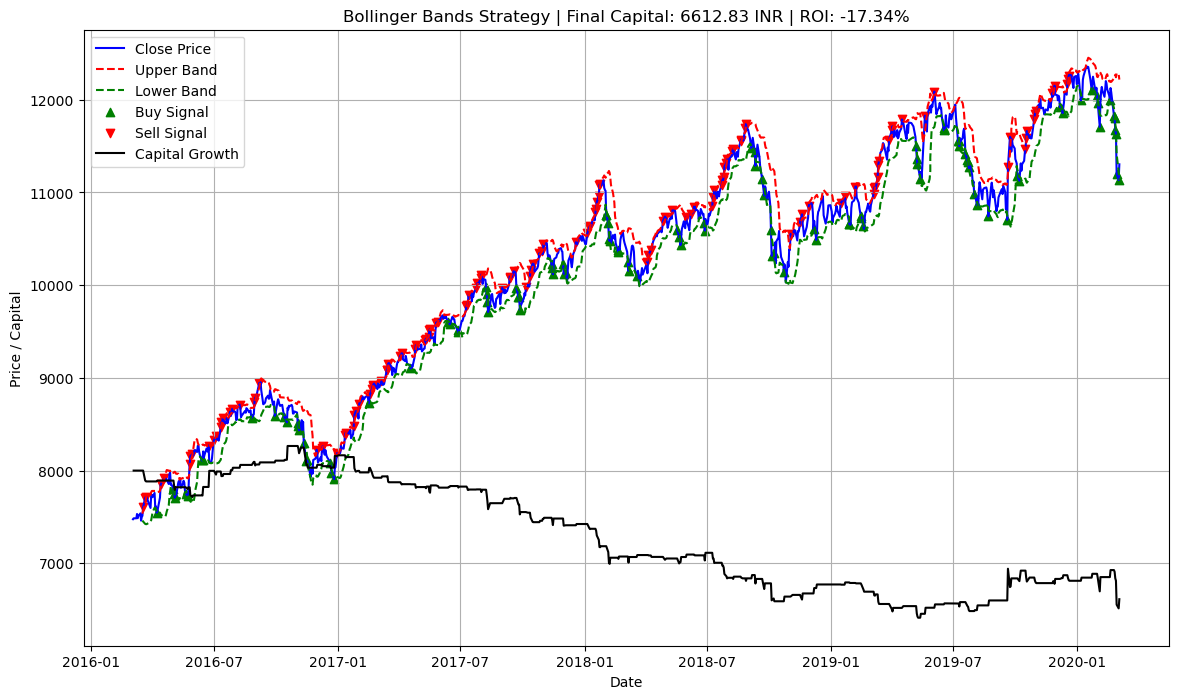


Final Capital: 6612.83 INR
ROI: -17.34%


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from forex_python.converter import CurrencyRates

# Currency converter instance
currency_converter = CurrencyRates()

# Function to convert currency
def convert_currency(amount, from_currency, to_currency):
    conversion_rate = currency_converter.get_rate(from_currency, to_currency)
    return amount * conversion_rate

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to visualize the strategy with capital and ROI
def visualize_strategy(data, strategy_name, initial_capital, target_currency):
    data['Position'] = data['Signal'].shift(1).fillna(0)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')

    if strategy_name == 'Bollinger Bands':
        plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
        plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    
    elif strategy_name == 'SMA Crossover':
        plt.plot(data.index, data['SMA_Short'], label='Short-term SMA', color='orange')
        plt.plot(data.index, data['SMA_Long'], label='Long-term SMA', color='purple')

    plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Close'], 
                label='Buy Signal', marker='^', color='green')
    plt.scatter(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['Close'], 
                label='Sell Signal', marker='v', color='red')
    
    plt.plot(data.index, data['Capital'], label='Capital Growth', color='black')
    plt.title(f'{strategy_name} Strategy | Final Capital: {final_capital:.2f} {target_currency} | ROI: {roi:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Price / Capital')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"ROI: {roi:.2f}%")

# Main function to load data and apply strategies
def main():
    # Load dataset
    file_path = input("Enter the path of your dataset (CSV format): ")
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital
    capital_inr = float(input("Enter your initial capital (in INR): "))
    
    # Currency conversion
    indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    index_choice = int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = list(indices.values())[index_choice - 1]
    
    if target_currency != 'INR':
        capital_converted = convert_currency(capital_inr, 'INR', target_currency)
    else:
        capital_converted = capital_inr

    # Select investment style
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nSelect Investment Style:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    style_choice = int(input("Select a style (1-3): "))
    investment_style = styles[style_choice - 1]
    
    # Adjust parameters based on style
    params = adjust_strategy_parameters(investment_style)

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply the selected strategy
    
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data, params['bollinger_window'], params['bollinger_std'])
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data, params['sma_short'], params['sma_long'])
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI
    visualize_strategy(data, strategy_name, capital_converted, target_currency)

if __name__ == "__main__":
    main()


Enter the path of your dataset (CSV format):  /Users/kartikeysharma/Desktop/Hanuman/Projects/Prodigal Stock Data/Nifty50_data.csv
Enter start date (YYYY-MM-DD):  2016-03-03
Enter end date (YYYY-MM-DD):  2020-03-03
Enter your initial capital (in INR):  10000
Select a country (1: India, 2: USA, 3: Japan):  1



Select Investment Style:
1. Aggressive
2. Moderate
3. Passive


Select a style (1-3):  3
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  1


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/3662779436.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_2101/3662779436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal


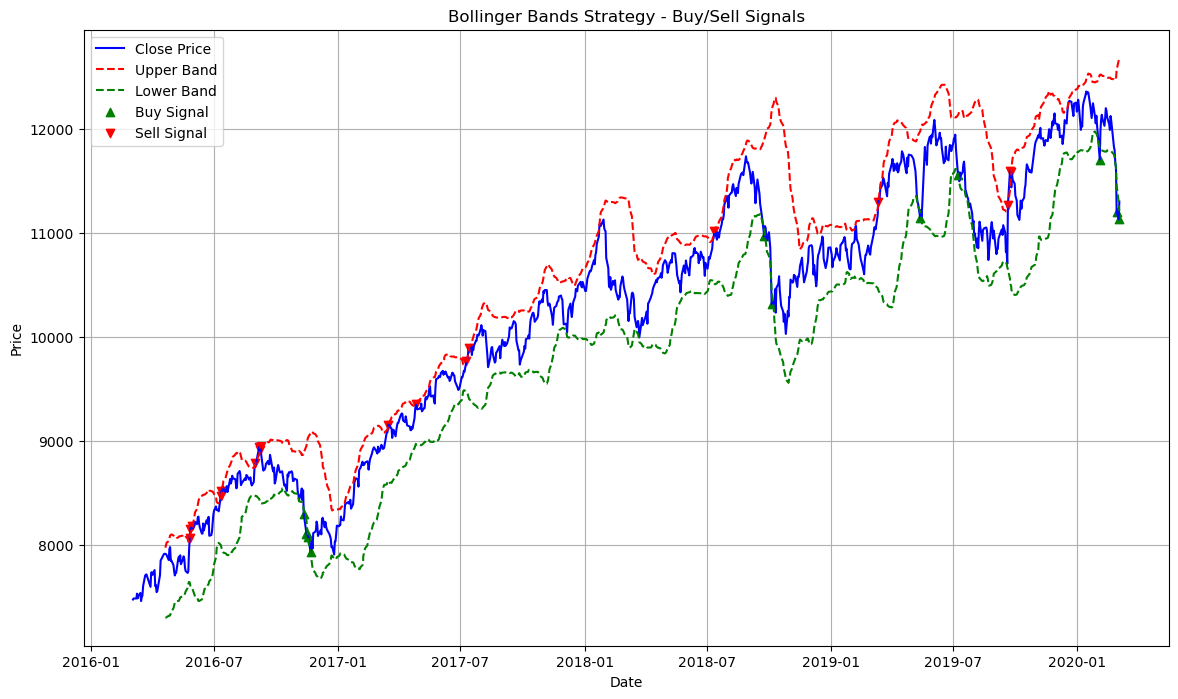

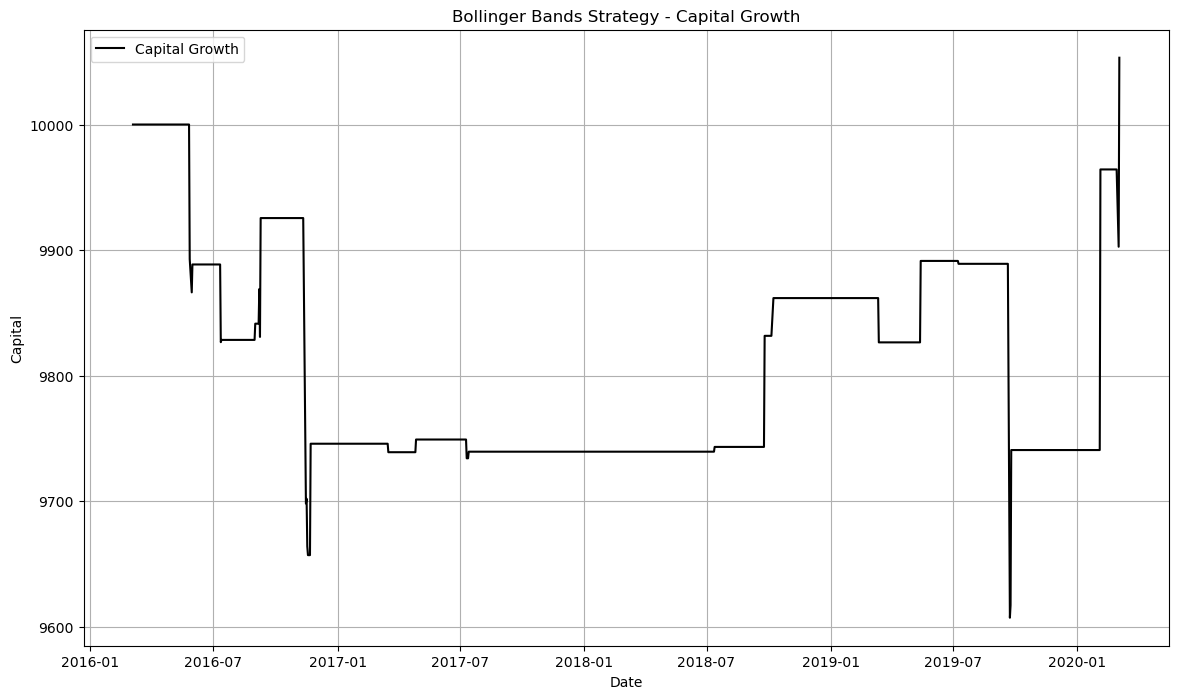


Final Capital: 10053.20 INR
ROI: 0.53%


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from forex_python.converter import CurrencyRates

# Currency converter instance
currency_converter = CurrencyRates()

# Function to convert currency
def convert_currency(amount, from_currency, to_currency):
    conversion_rate = currency_converter.get_rate(from_currency, to_currency)
    return amount * conversion_rate

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to visualize buy/sell signals and cumulative capital separately
def visualize_strategy(data, strategy_name, initial_capital, target_currency):
    data['Position'] = data['Signal'].shift(1).fillna(0)  # Positions based on previous signals
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))  # Daily returns
    data['Strategy_Returns'] = data['Position'] * data['Returns']  # Strategy returns
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()  # Cumulative returns
    
    # Calculate capital over time
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Plot 1: Buy/Sell Signals
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    
    if strategy_name == 'Bollinger Bands':
        plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
        plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    
    elif strategy_name == 'SMA Crossover':
        plt.plot(data.index, data['SMA_Short'], label='Short-term SMA', color='orange')
        plt.plot(data.index, data['SMA_Long'], label='Long-term SMA', color='purple')
    
    plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Close'], 
                label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['Close'], 
                label='Sell Signal', marker='v', color='red', alpha=1)
    
    plt.title(f'{strategy_name} Strategy - Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Cumulative Capital Growth
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Capital'], label='Capital Growth', color='black')
    plt.title(f'{strategy_name} Strategy - Capital Growth')
    plt.xlabel('Date')
    plt.ylabel('Capital')
    plt.legend()
    plt.grid()
    plt.show()

    # Final capital and ROI
    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"ROI: {roi:.2f}%")

# Main function to load data and apply strategies
def main():
    # Load dataset
    file_path = input("Enter the path of your dataset (CSV format): ")
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital
    capital_inr = float(input("Enter your initial capital (in INR): "))
    
    # Currency conversion
    indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    index_choice = int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = list(indices.values())[index_choice - 1]
    
    if target_currency != 'INR':
        capital_converted = convert_currency(capital_inr, 'INR', target_currency)
    else:
        capital_converted = capital_inr

    # Select investment style
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nSelect Investment Style:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    style_choice = int(input("Select a style (1-3): "))
    investment_style = styles[style_choice - 1]
    
    # Adjust parameters based on style
    params = adjust_strategy_parameters(investment_style)

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply the selected strategy
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data, params['bollinger_window'], params['bollinger_std'])
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data, params['sma_short'], params['sma_long'])
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI
    visualize_strategy(data, strategy_name, capital_converted, target_currency)

if __name__ == "__main__":
    main()


Enter the path of your dataset (CSV format):  /Users/kartikeysharma/Desktop/Hanuman/Projects/Prodigal Stock Data/Nifty50_data.csv
Enter start date (YYYY-MM-DD):  2020-03-03
Enter end date (YYYY-MM-DD):  2024-05-03
Enter your initial capital (in INR):  10000
Select a country (1: India, 2: USA, 3: Japan):  1



Select Investment Style:
1. Aggressive
2. Moderate
3. Passive


Select a style (1-3):  2
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  1


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_3455/3987265744.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_3455/3987265744.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



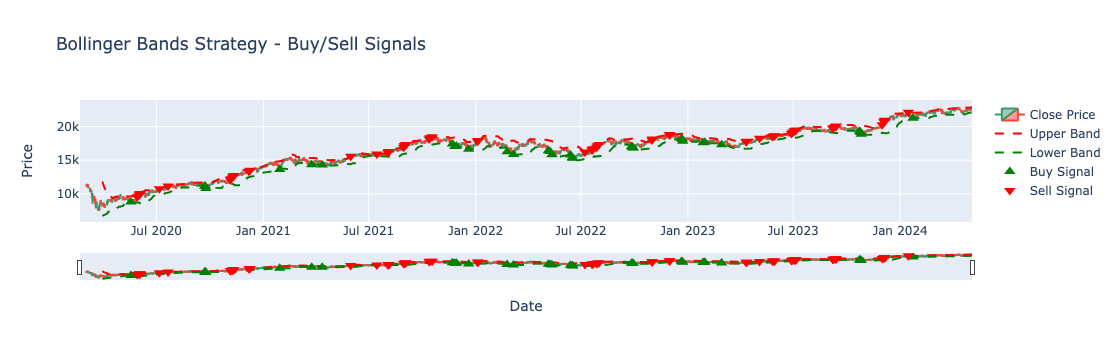

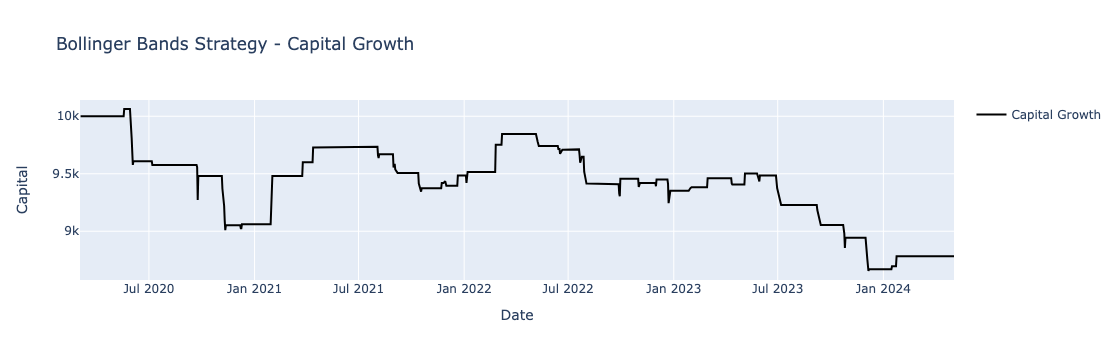


Final Capital: 8782.84 INR
ROI: -12.17%


In [5]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from forex_python.converter import CurrencyRates

# Currency converter instance
currency_converter = CurrencyRates()

# Function to convert currency
def convert_currency(amount, from_currency, to_currency):
    conversion_rate = currency_converter.get_rate(from_currency, to_currency)
    return amount * conversion_rate

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to create interactive Plotly visualization for buy/sell signals and capital growth
def visualize_interactive(data, strategy_name, initial_capital, target_currency):
    data['Position'] = data['Signal'].shift(1).fillna(0)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Plot 1: Buy/Sell Signals
    fig1 = go.Figure()

    # Plot Close Price
    fig1.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Close Price'
    ))

    if strategy_name == 'Bollinger Bands':
        fig1.add_trace(go.Scatter(x=data.index, y=data['Upper Band'], mode='lines', name='Upper Band', line=dict(dash='dash', color='red')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['Lower Band'], mode='lines', name='Lower Band', line=dict(dash='dash', color='green')))
    
    elif strategy_name == 'SMA Crossover':
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='Short-term SMA', line=dict(color='orange')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='Long-term SMA', line=dict(color='purple')))

    # Add Buy and Sell signals
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == 1].index, y=data[data['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=10)))
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == -1].index, y=data[data['Signal'] == -1]['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=10)))

    fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True)#,height=800,   width=1200,yaxis=dict(
            #range=[data['Close'].min() - 5, data['Close'].max() + 5] ))

    # fig1.update_layout(
    #     title=f'{strategy_name} Strategy - Buy/Sell Signals',
    #     xaxis_title='Date',
    #     yaxis_title='Price',
    #     showlegend=True,
    #     height=700,  # Adjust height to make plot taller
    #     width=1200,  # Adjust width for better spread visibility
    #     yaxis=dict(
    #         range=[data['Close'].min() - 5, data['Close'].max() + 5]  # Adjust y-axis range for better view of spread
    #     )
    # )
    
    fig1.show()

    # Plot 2: Capital Growth
    fig2 = go.Figure()

    fig2.add_trace(go.Scatter(x=data.index, y=data['Capital'], mode='lines', name='Capital Growth', line=dict(color='black')))
    fig2.update_layout(title=f'{strategy_name} Strategy - Capital Growth', xaxis_title='Date', yaxis_title='Capital', showlegend=True)

    fig2.show()

    # Final capital and ROI
    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"ROI: {roi:.2f}%")

# Main function to load data and apply strategies
def main():
    # Load dataset
    file_path = input("Enter the path of your dataset (CSV format): ")
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital
    capital_inr = float(input("Enter your initial capital (in INR): "))
    
    # Currency conversion
    indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    index_choice = int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = list(indices.values())[index_choice - 1]
    
    if target_currency != 'INR':
        capital_converted = convert_currency(capital_inr, 'INR', target_currency)
    else:
        capital_converted = capital_inr

    # Select investment style
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nSelect Investment Style:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    style_choice = int(input("Select a style (1-3): "))
    investment_style = styles[style_choice - 1]
    
    # Adjust parameters based on style
    params = adjust_strategy_parameters(investment_style)

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply the selected strategy
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data, params['bollinger_window'], params['bollinger_std'])
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data, params['sma_short'], params['sma_long'])
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI with interactive Plotly charts
    visualize_interactive(data, strategy_name, capital_converted, target_currency)

if __name__ == "__main__":
    main()


Enter the path of your dataset (CSV format):  /Users/kartikeysharma/Desktop/Hanuman/Projects/Prodigal Stock Data/Nifty50_data.csv
Enter start date (YYYY-MM-DD):  2007-09-17
Enter end date (YYYY-MM-DD):  2024-10-01
Enter your initial capital (in INR):  10000
Select a country (1: India, 2: USA, 3: Japan):  1



Select Investment Style:
1. Aggressive
2. Moderate
3. Passive


Select a style (1-3):  3
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  1


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_3455/3356225169.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_3455/3356225169.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



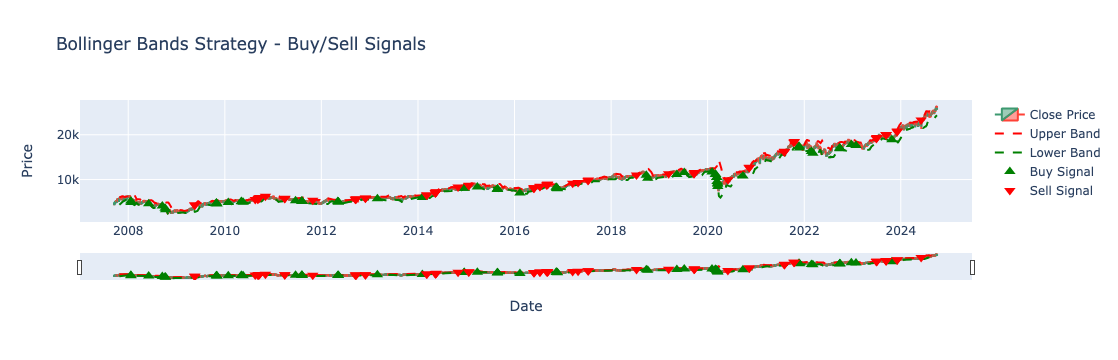

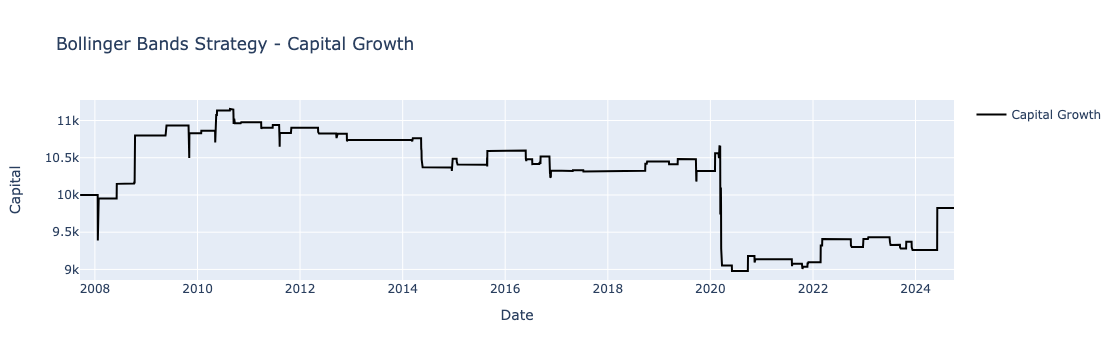


Final Capital: 9826.53 INR
Cumulative ROI: -1.73%


In [20]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from forex_python.converter import CurrencyRates

# Currency converter instance
currency_converter = CurrencyRates()

# Function to convert currency
def convert_currency(amount, from_currency, to_currency):
    conversion_rate = currency_converter.get_rate(from_currency, to_currency)
    return amount * conversion_rate

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to create interactive Plotly visualization for buy/sell signals and capital growth
def visualize_interactive(data, strategy_name, initial_capital, target_currency):
    # Calculate log returns
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Shift the Signal to indicate trades made at the close of the previous day
    data['Position'] = data['Signal'].shift(1).fillna(0)
    
    # Calculate strategy returns based on positions
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    
    # Calculate cumulative returns
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time based on cumulative strategy returns
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    
    # Calculate cumulative ROI
    cumulative_roi = (data['Capital'].iloc[-1] - initial_capital) / initial_capital * 100

    # Check for negative capital growth and print debugging information
    if data['Capital'].min() < 0:
        print("\nWarning: Negative capital detected. Check signal logic and returns calculation.")
        print(data[['Close', 'Signal', 'Position', 'Returns', 'Strategy_Returns', 'Capital']].tail(10))

    # Plot 1: Buy/Sell Signals
    fig1 = go.Figure()

    # Plot Close Price
    fig1.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Close Price'
    ))

    if strategy_name == 'Bollinger Bands':
        fig1.add_trace(go.Scatter(x=data.index, y=data['Upper Band'], mode='lines', name='Upper Band', line=dict(dash='dash', color='red')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['Lower Band'], mode='lines', name='Lower Band', line=dict(dash='dash', color='green')))
    
    elif strategy_name == 'SMA Crossover':
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='Short-term SMA', line=dict(color='orange')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='Long-term SMA', line=dict(color='purple')))

    # Add Buy and Sell signals
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == 1].index, y=data[data['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=10)))
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == -1].index, y=data[data['Signal'] == -1]['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=10)))

    fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True)
    fig1.show()

    # Plot 2: Capital Growth
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=data.index, y=data['Capital'], mode='lines', name='Capital Growth', line=dict(color='black')))
    fig2.update_layout(title=f'{strategy_name} Strategy - Capital Growth', xaxis_title='Date', yaxis_title='Capital', showlegend=True)
    fig2.show()

    # Display Final Capital and ROI
    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"Cumulative ROI: {cumulative_roi:.2f}%")


# Main function to load data and apply strategies
def main():
    # Load dataset
    file_path = input("Enter the path of your dataset (CSV format): ")
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital
    capital_inr = float(input("Enter your initial capital (in INR): "))
    
    # Currency conversion
    indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    index_choice = int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = list(indices.values())[index_choice - 1]
    
    if target_currency != 'INR':
        capital_converted = convert_currency(capital_inr, 'INR', target_currency)
    else:
        capital_converted = capital_inr

    # Select investment style
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nSelect Investment Style:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    style_choice = int(input("Select a style (1-3): "))
    investment_style = styles[style_choice - 1]
    
    # Adjust parameters based on style
    params = adjust_strategy_parameters(investment_style)

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply the selected strategy
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data, params['bollinger_window'], params['bollinger_std'])
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data, params['sma_short'], params['sma_long'])
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI with interactive Plotly charts
    visualize_interactive(data, strategy_name, capital_converted, target_currency)

if __name__ == "__main__":
    main()
